In [1]:
import sys
import os

sys.path.append('../src')

In [3]:
import argparse
import torch
import pytorch_warmup as warmup
import wandb
from tqdm import tqdm
import yaml
import sys
import os

import torch
import torch.optim as optim
import torch.nn as nn
import numpy as np

from mamba_ssm.models.config_mamba import MambaConfig

from datasets import load_dataset
from transformers import AutoTokenizer, DataCollatorWithPadding
from torch.utils.data import DataLoader
from peft import LoraConfig, get_peft_model

from utils import print_model_size, fix_seed
from models.MambaWithEmbeddings import MambaLMHeadModelWithEmbeddings
from training_functions import add_special_token

In [6]:
dataset = load_dataset("yelp_polarity")
tokenizer = AutoTokenizer.from_pretrained("EleutherAI/gpt-neox-20b")

if tokenizer.pad_token is None:
    # tokenizer.add_special_tokens({'pad_token': '[PAD]'})
    tokenizer.add_special_tokens({'pad_token': tokenizer.eos_token})

# def tokenize_function(examples):
#     return tokenizer(examples["text"], padding=True, truncation=True, max_length=512)

def tokenize_function(examples):
    return tokenizer(examples["text"], padding=False, truncation=False)

tokenized_datasets = dataset.map(tokenize_function, batched=True, remove_columns=["text"])

data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="pt")

train_dataset = tokenized_datasets["train"]
test_dataset = tokenized_datasets["test"]

train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True, collate_fn=data_collator)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False, collate_fn=data_collator)

Map: 100%|██████████████████████████████████████████████████████████████████████████████████████| 38000/38000 [00:05<00:00, 7236.91 examples/s]


In [ ]:
import matplotlib.pyplot as plt

# Соберем длины токенизированных последовательностей
sequence_lengths = [len(example["input_ids"]) for example in train_dataset]

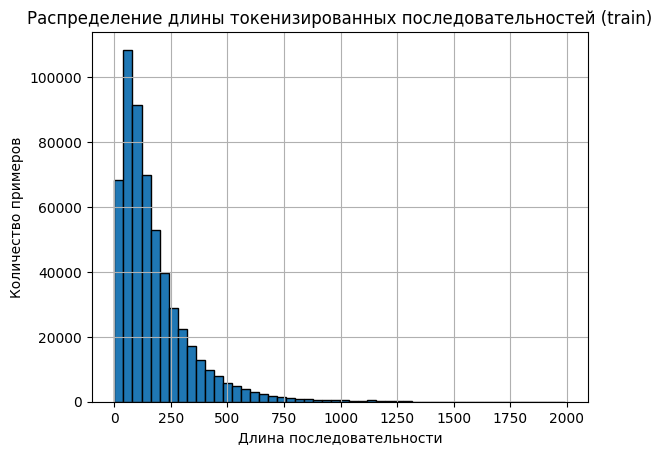

In [13]:
# Нарисуем гистограмму
plt.hist(sequence_lengths, bins=50, edgecolor='black')
plt.title("Распределение длины токенизированных последовательностей (train)")
plt.xlabel("Длина последовательности")
plt.ylabel("Количество примеров")
plt.grid(True)
plt.show()

In [14]:
import numpy as np

print("Минимум:", np.min(sequence_lengths))
print("Максимум:", np.max(sequence_lengths))
print("Средняя длина:", np.mean(sequence_lengths))
print("Медиана:", np.median(sequence_lengths))


Минимум: 1
Максимум: 1993
Средняя длина: 175.50352142857142
Медиана: 127.0


In [16]:
count_below_256 = sum(1 for x in sequence_lengths if x < 256)
percent_below_256 = (count_below_256 / len(sequence_lengths)) * 100

print(f"Percent of numbers less than 256: {percent_below_256:.2f}%")

Percent of numbers less than 256: 50.31%


In [17]:
dataset = load_dataset("yelp_polarity")
tokenizer = AutoTokenizer.from_pretrained("EleutherAI/gpt-neox-20b")

if tokenizer.pad_token is None:
    tokenizer.add_special_tokens({'pad_token': tokenizer.eos_token})

def tokenize_function_with_len(examples):
    tokens = tokenizer(examples["text"], padding=False, truncation=False)
    tokens["length"] = [len(x) for x in tokens["input_ids"]]
    return tokens

tokenized_datasets = dataset.map(tokenize_function_with_len, batched=True, remove_columns=["text"])

Map: 100%|██████████████████████████████████████████████████████████████████████████████████████| 38000/38000 [00:04<00:00, 7878.55 examples/s]


In [18]:
from datasets import concatenate_datasets

short_length = 128
long_length = 512

short_train = tokenized_datasets["train"].filter(lambda x: x["length"] <= short_length)
short_test = tokenized_datasets["test"].filter(lambda x: x["length"] <= short_length)
long_train = tokenized_datasets["train"].filter(lambda x: x["length"] >= long_length)
long_test = tokenized_datasets["test"].filter(lambda x: x["length"] >= long_length)

new_train_dataset = concatenate_datasets([short_train, short_test])
new_test_dataset = concatenate_datasets([long_train, long_test])

Filter: 100%|███████████████████████████████████████████████████████████████████████████████████| 38000/38000 [00:05<00:00, 6650.86 examples/s]


In [19]:
print(f"Short samples in new train: {len(new_train_dataset)}")
print(f"Long samples in new test: {len(new_test_dataset)}")


Short samples in new train: 302960
Long samples in new test: 27098


In [35]:
seed = 42
model_name = "state-spaces/mamba-130m"

In [99]:
fix_seed(seed)
model = MambaLMHeadModelWithEmbeddings.from_pretrained(model_name, num_labels=2)

In [100]:
model

MambaLMHeadModelWithEmbeddings(
  (backbone): MixerModelWithEmbeddings(
    (embedding): Embedding(50280, 768)
    (layers): ModuleList(
      (0-23): 24 x Block(
        (norm): RMSNorm()
        (mixer): Mamba(
          (in_proj): Linear(in_features=768, out_features=3072, bias=False)
          (conv1d): Conv1d(1536, 1536, kernel_size=(4,), stride=(1,), padding=(3,), groups=1536)
          (act): SiLU()
          (x_proj): Linear(in_features=1536, out_features=80, bias=False)
          (dt_proj): Linear(in_features=48, out_features=1536, bias=True)
          (out_proj): Linear(in_features=1536, out_features=768, bias=False)
        )
      )
    )
    (norm_f): RMSNorm()
  )
  (lm_head): Linear(in_features=768, out_features=50280, bias=False)
  (classification_head): Linear(in_features=768, out_features=2, bias=True)
)

## LoRA

In [101]:
import types

def get_method(self, key, default=None):
    return getattr(self, key, default)

model.config.get = types.MethodType(get_method, model.config)

In [102]:
model.config

MambaConfig(d_model=768, d_intermediate=0, n_layer=24, vocab_size=50277, ssm_cfg={}, attn_layer_idx=[], attn_cfg={}, rms_norm=True, residual_in_fp32=True, fused_add_norm=True, pad_vocab_size_multiple=8, tie_embeddings=True)

In [103]:
lora_config = LoraConfig(
    r=8,
    lora_alpha=16,
    lora_dropout=0.1,
    bias="none",
    target_modules=["in_proj", "x_proj", "dt_proj", "out_proj"],
    # target_modules=["in_proj", "out_proj"],
)

model = get_peft_model(model, lora_config)

In [104]:
model

PeftModel(
  (base_model): LoraModel(
    (model): MambaLMHeadModelWithEmbeddings(
      (backbone): MixerModelWithEmbeddings(
        (embedding): Embedding(50280, 768)
        (layers): ModuleList(
          (0-23): 24 x Block(
            (norm): RMSNorm()
            (mixer): Mamba(
              (in_proj): lora.Linear(
                (base_layer): Linear(in_features=768, out_features=3072, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.1, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=768, out_features=8, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=8, out_features=3072, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
                (lora_magnitude_vector): ModuleDict()
              )
              (conv

In [105]:
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Обучаемых параметров: {trainable_params:,}")

Обучаемых параметров: 1,794,048


In [106]:
# model.freeze_layers()

In [107]:
model.backbone.layers[-1].mixer.out_proj.weight

Parameter containing:
tensor([[ 0.1919, -0.0347,  0.0941,  ..., -0.1357,  0.1383, -0.0218],
        [ 0.0317,  0.0470, -0.2262,  ..., -0.1767,  0.0739,  0.0479],
        [-0.0528,  0.1756,  0.1555,  ...,  0.2199, -0.1916, -0.0371],
        ...,
        [-0.1702, -0.0906, -0.0830,  ..., -0.0135, -0.0842,  0.0020],
        [ 0.0432,  0.0286, -0.1470,  ...,  0.0472,  0.0670, -0.1609],
        [ 0.1678,  0.0724,  0.0571,  ..., -0.1032, -0.0364,  0.0401]])

In [108]:
model.classification_head.weight

Parameter containing:
tensor([[ 0.0009,  0.0087,  0.0269,  ...,  0.0269, -0.0181,  0.0178],
        [-0.0118,  0.0232,  0.0009,  ...,  0.0321, -0.0164, -0.0025]])

In [109]:
# Замораживаем все слои кроме LoRA и классификационной головы
for name, param in model.named_parameters():
    if "lora" not in name and "classification_head" not in name:
        param.requires_grad = False
    else:
        param.requires_grad = True

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=0.0001)

In [110]:
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Обучаемых параметров: {trainable_params:,}")

Обучаемых параметров: 1,795,586


In [111]:
gpu_number = 0
device = torch.device(f'cuda:{gpu_number}' if torch.cuda.is_available() else 'cpu')

In [115]:
num_epochs = 3
learning_rate = 0.0001
tokens_num = 100
period = 50
warmup_percent = 0.05
accumulation_steps = 1

In [118]:
total_steps = num_epochs * len(train_dataloader) / accumulation_steps
warmup_steps = int(warmup_percent * total_steps)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=total_steps, eta_min=5e-6)
warmup_scheduler = warmup.LinearWarmup(optimizer, warmup_steps)

fix_seed(seed)
model.to(device)

for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0.0
    correct_train = 0
    total_train = 0

    pbar = tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{num_epochs} - Training")
    optimizer.zero_grad()
    accumulated_loss = 0.0
    accumulated_correct = 0
    accumulated_total = 0
    
    for step, batch in enumerate(pbar):
        inputs, labels = batch['input_ids'], batch['labels']
        inputs, labels = inputs.to(device), labels.to(device)
        
        outputs = model(inputs, num_last_tokens=1)
        logits = outputs.logits[:, 0, :]
        loss = criterion(logits, labels)
        
        loss = loss / accumulation_steps  # Для градиентного накопления
        loss.backward()
        
        accumulated_loss += loss.item()
        _, predicted = logits.max(1)
        accumulated_total += labels.size(0)
        accumulated_correct += predicted.eq(labels).sum().item()
        
        if (step + 1) % accumulation_steps == 0 or (step + 1) == len(train_dataloader):
            optimizer.step()
            optimizer.zero_grad()
            
            with warmup_scheduler.dampening():
                scheduler.step()
            
            total_train_loss += accumulated_loss
            total_train += accumulated_total
            correct_train += accumulated_correct
            
            # wandb.log({
            #     "train_loss_step": accumulated_loss,
            #     "train_accuracy_step": accumulated_correct / accumulated_total,
            #     "lr_step": optimizer.param_groups[0]['lr']
            # })
            
            pbar.set_postfix({"Train Loss (batch)": accumulated_loss})
            
            accumulated_loss = 0.0
            accumulated_correct = 0
            accumulated_total = 0
    
    train_accuracy_epoch = 100 * correct_train / total_train
    # wandb.log({
    #     "train_loss_epoch": total_train_loss / len(train_dataloader),
    #     "train_accuracy_epoch": train_accuracy_epoch
    # })
    
    val_batch_losses, val_accuracy = inference(model, val_loader, device, criterion=criterion, num_last_tokens=1)
    val_loss = sum(val_batch_losses) / len(val_batch_losses)
    
    # wandb.log({
    #     "val_loss_epoch": val_loss,
    #     "val_accuracy_epoch": val_accuracy
    # })

Epoch 1/3 - Training:   7%|███▌                                                 | 2378/35000 [14:16<3:15:53,  2.78it/s, Train Loss (batch)=0.878]


KeyboardInterrupt: 

## Special token learning

In [52]:
num_epochs = 3
learning_rate = 0.0001
tokens_num = 100
period = 50
warmup_percent = 0.05

In [55]:
import time
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

special_token = torch.randn(1, tokens_num, model.config.d_model, requires_grad=True, device=device)
model.to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()

optimizer = optim.AdamW(
    [{'params': [special_token], 'lr': learning_rate},
     {'params': model.parameters(), 'lr': learning_rate}],
)

total_steps = num_epochs * len(train_dataloader)
warmup_steps = int(warmup_percent * total_steps)  # Calculate warmup steps as a percentage of total steps
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=total_steps, eta_min=5e-6)
warmup_scheduler = warmup.LinearWarmup(optimizer, warmup_steps)

fix_seed(seed)

i = 0

for epoch in range(num_epochs):
    model.train()  # Set model to evaluation mode
    train_loss = 0.0
    correct_train = 0
    total_train = 0

    pbar = tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{num_epochs} - Training")
    for batch in pbar:
        i += 1

        if i == 10:
            break
        batch_start_time = time.time()
        torch.cuda.synchronize()
        inputs, labels = batch['input_ids'], batch['labels']
        
        # Move data to the specified device
        start = time.time()
        torch.cuda.synchronize()
        inputs, labels = inputs.to(device), labels.to(device)
        torch.cuda.synchronize()
        print(f"Data Transfer: {time.time() - start:.4f}s")

        # Convert inputs to embeddings without tracking gradients
        start = time.time()
        torch.cuda.synchronize()
        with torch.no_grad():
            embedded_inputs = model.backbone.embedding(inputs)
        torch.cuda.synchronize()
        print(f"Embedding Conversion: {time.time() - start:.4f}s")

        # Add special token
        start = time.time()
        torch.cuda.synchronize()
        embedded_with_special = add_special_token(embedded_inputs, special_token, period, tokens_num)
        torch.cuda.synchronize()
        print(f"Add Special Token: {time.time() - start:.4f}s")
        
        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        start = time.time()
        torch.cuda.synchronize()
        outputs = model(embedded_with_special, is_embeds=True, num_last_tokens=1)
        torch.cuda.synchronize()
        print(f"Forward Pass: {time.time() - start:.4f}s")
        
        logits = outputs.logits[:, 0, :]
        loss = criterion(logits, labels)

        # Backward pass and optimization
        start = time.time()
        torch.cuda.synchronize()
        loss.backward()
        optimizer.step()
        torch.cuda.synchronize()
        print(f"Backward Pass & Optimization: {time.time() - start:.4f}s")
        
        # Apply warmup and scheduler updates
        start = time.time()
        torch.cuda.synchronize()
        with warmup_scheduler.dampening():
            scheduler.step()
        torch.cuda.synchronize()
        print(f"Scheduler Update: {time.time() - start:.4f}s")

        # Accumulate training loss and accuracy
        train_loss += loss.item()
        _, predicted = logits.max(1)
        total_train += labels.size(0)
        correct_train += predicted.eq(labels).sum().item()

        # Calculate local train accuracy
        train_accuracy_local = 100 * correct_train / total_train
        
        # Display the current loss for each training batch
        pbar.set_postfix({"Train Loss (batch)": loss.item()})

        torch.cuda.synchronize()
        print(f"Total Batch Time: {time.time() - batch_start_time:.4f}s")
    break

    # ---- Epoch-Based Logging ----
    train_accuracy_epoch = 100 * correct_train / total_train

    # ---- Validation phase after each epoch ----
    val_batch_losses_local, val_accuracy = inference(
        model, val_loader, device, criterion=criterion, num_last_tokens=1, special_token=special_token, period=period
    )
    val_loss = sum(val_batch_losses_local) / len(val_batch_losses_local)


Epoch 1/3 - Training:   0%|                                                                                            | 0/35000 [00:00<?, ?it/s]

Data Transfer: 0.0002s
Embedding Conversion: 0.0004s
Add Special Token: 0.0007s
Forward Pass: 0.4747s


Epoch 1/3 - Training:   0%|                                                        | 1/35000 [00:01<10:50:33,  1.12s/it, Train Loss (batch)=1.17]

Backward Pass & Optimization: 0.5788s
Scheduler Update: 0.0001s
Total Batch Time: 1.0602s
Data Transfer: 0.0001s
Embedding Conversion: 0.0002s
Add Special Token: 0.0005s
Forward Pass: 0.3824s


Epoch 1/3 - Training:   0%|                                                        | 2/35000 [00:02<10:01:09,  1.03s/it, Train Loss (batch)=1.48]

Backward Pass & Optimization: 0.5732s
Scheduler Update: 0.0001s
Total Batch Time: 0.9592s
Data Transfer: 0.0001s
Embedding Conversion: 0.0002s
Add Special Token: 0.0004s
Forward Pass: 0.3825s


Epoch 1/3 - Training:   0%|                                                         | 3/35000 [00:03<9:45:24,  1.00s/it, Train Loss (batch)=1.32]

Backward Pass & Optimization: 0.5745s
Scheduler Update: 0.0001s
Total Batch Time: 0.9602s
Data Transfer: 0.0001s
Embedding Conversion: 0.0001s
Add Special Token: 0.0004s
Forward Pass: 0.3825s


Epoch 1/3 - Training:   0%|                                                         | 4/35000 [00:04<9:38:16,  1.01it/s, Train Loss (batch)=1.11]

Backward Pass & Optimization: 0.5757s
Scheduler Update: 0.0001s
Total Batch Time: 0.9612s
Data Transfer: 0.0001s
Embedding Conversion: 0.0001s
Add Special Token: 0.0004s
Forward Pass: 0.3811s


Epoch 1/3 - Training:   0%|                                                         | 5/35000 [00:05<9:34:43,  1.01it/s, Train Loss (batch)=1.04]

Backward Pass & Optimization: 0.5763s
Scheduler Update: 0.0001s
Total Batch Time: 0.9605s
Data Transfer: 0.0001s
Embedding Conversion: 0.0001s
Add Special Token: 0.0004s
Forward Pass: 0.3849s


Epoch 1/3 - Training:   0%|                                                         | 6/35000 [00:05<9:32:28,  1.02it/s, Train Loss (batch)=0.95]

Backward Pass & Optimization: 0.5748s
Scheduler Update: 0.0001s
Total Batch Time: 0.9628s
Data Transfer: 0.0001s
Embedding Conversion: 0.0001s
Add Special Token: 0.0004s
Forward Pass: 0.3831s


Epoch 1/3 - Training:   0%|                                                        | 7/35000 [00:06<9:30:58,  1.02it/s, Train Loss (batch)=0.892]

Backward Pass & Optimization: 0.5759s
Scheduler Update: 0.0001s
Total Batch Time: 0.9625s
Data Transfer: 0.0001s
Embedding Conversion: 0.0002s
Add Special Token: 0.0004s
Forward Pass: 0.3843s


Epoch 1/3 - Training:   0%|                                                        | 8/35000 [00:07<9:30:15,  1.02it/s, Train Loss (batch)=0.776]

Backward Pass & Optimization: 0.5760s
Scheduler Update: 0.0001s
Total Batch Time: 0.9635s
Data Transfer: 0.0001s
Embedding Conversion: 0.0001s
Add Special Token: 0.0004s
Forward Pass: 0.3839s


Epoch 1/3 - Training:   0%|                                                         | 9/35000 [00:08<9:38:08,  1.01it/s, Train Loss (batch)=1.27]

Backward Pass & Optimization: 0.5764s
Scheduler Update: 0.0001s
Total Batch Time: 0.9633s


In [57]:
special_token.size()

torch.Size([1, 100, 768])

In [58]:
print_model_size(model)

Model parameters number: 129136898
Model size: 492.62 MB
Model size: 0.48 GB


In [62]:
print_model_size(model.classification_head)

Model parameters number: 1538
Model size: 0.01 MB
Model size: 0.00 GB


In [66]:
len(train_dataset)

560000

In [67]:
len(test_dataset)

38000